# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

all_sw = stopwords.words('spanish')

In [2]:
df = pd.read_csv("Datathon 2024 - Reto Hey - Dataset Público - Sheet1.csv")
df['tweet'].iloc[7]

'Muchas gracias 😊'

## Wordcloud

### Removing Emojis

In [3]:
# Removing emojis as first attempt to create wordloud

def remove_emojis(text):
    return emoji.replace_emoji(text, '')

def emoji_to_text(text):
    return emoji.demojize(text)

def remove_stopwords(text):
    words = word_tokenize(text, language='spanish')
    return ' '.join([word.lower() for word in words if word.lower() not in all_sw])

def clean_text(df, emoji='remove', strip=True, sw=True):
    df1 = df.copy()
    if emoji == 'remove':
        df1['clean_tweet'] = df1['tweet'].apply(remove_emojis)
    elif emoji == 'text':
        df1['clean_tweet'] = df1['tweet'].apply(emoji_to_text)
    
    if strip:
        df1['clean_tweet'] = df1['clean_tweet'].str.rstrip()
        df1['clean_tweet'] = df1['clean_tweet'].str.replace(r'\s+', ' ', regex=True).str.strip()

    if sw:
        df1['clean_tweet'] = df1['clean_tweet'].apply(remove_stopwords)
    return df1

In [4]:
df1 = clean_text(df)
df1['clean_tweet'].iloc[7]

'muchas gracias'

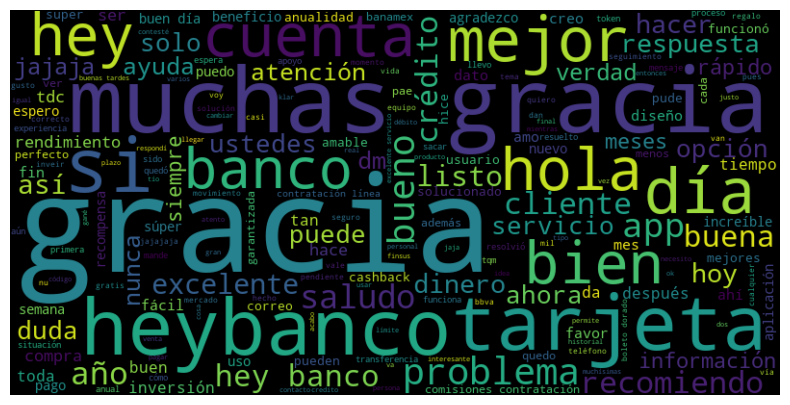

In [5]:
# Join all text in one string
text = ' '.join(df1['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### New stopwords

In [6]:
new_sw = ['heybanco', 'muchas', 'mucha', 'gracia', 'gracias', 'hola', 'día', 'si', 'tarjeta', 'listo', 'hey',
          'banco', 'tan', 'hace', 'solo', 'favor', 'ahora', 'así', 'días']
all_sw = list(all_sw) + new_sw

df2 = clean_text(df1, emoji='remove', strip=False)

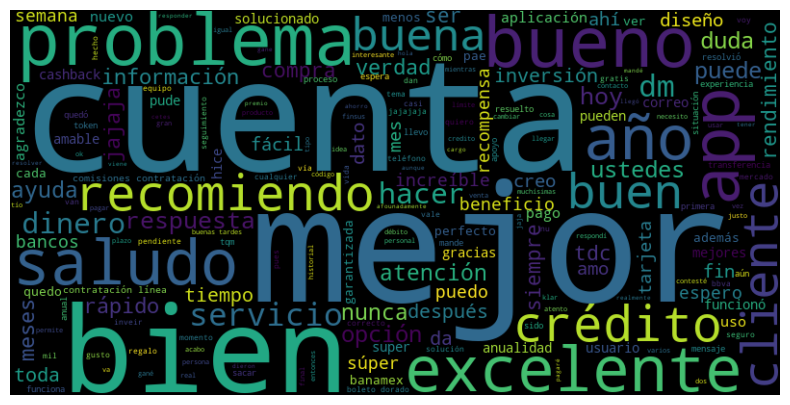

In [7]:
# Join all text in one string
text = ' '.join(df2['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

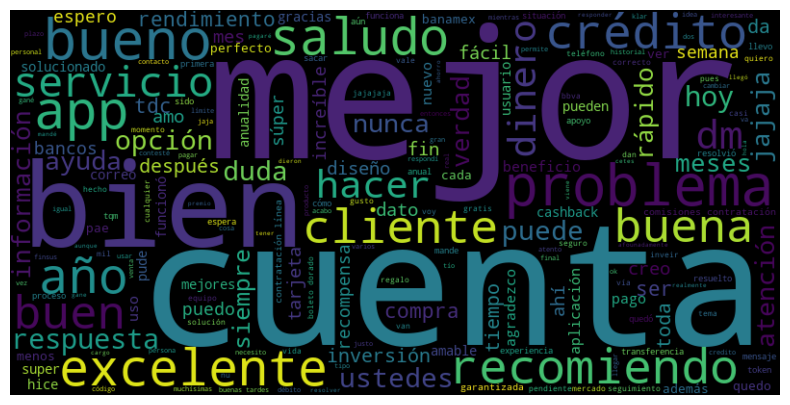

In [10]:
# Join all text in one string
text = ' '.join(df2['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Machine Learning

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [12]:
# TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_sw, ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(df2['clean_tweet'])

# Clustering
number_of_clusters = 4
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(X)

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(number_of_clusters):
    print('Cluster %d: ' %i),
for ind in order_centroids[i, :10]:
    print(' %s' % terms[ind])

Cluster 0: 
Cluster 1: 
Cluster 2: 
Cluster 3: 
 mejor
 bien
 saludos
 quedó
 jajaja
 recomiendo
 bueno
 buen
 ayuda
 problema


WordCloud for cluster 1


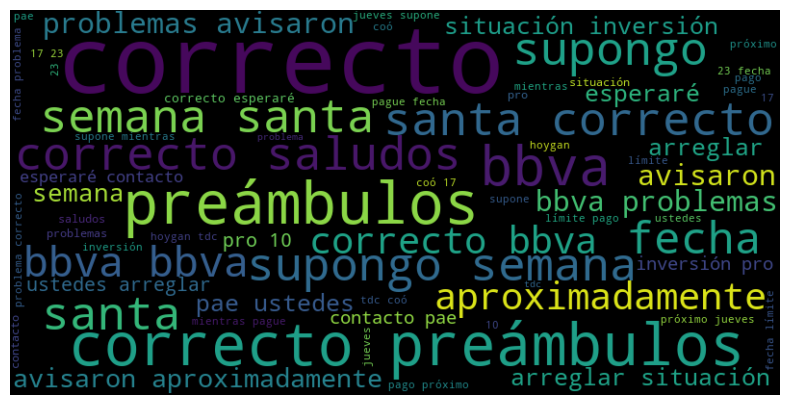

WordCloud for cluster 2


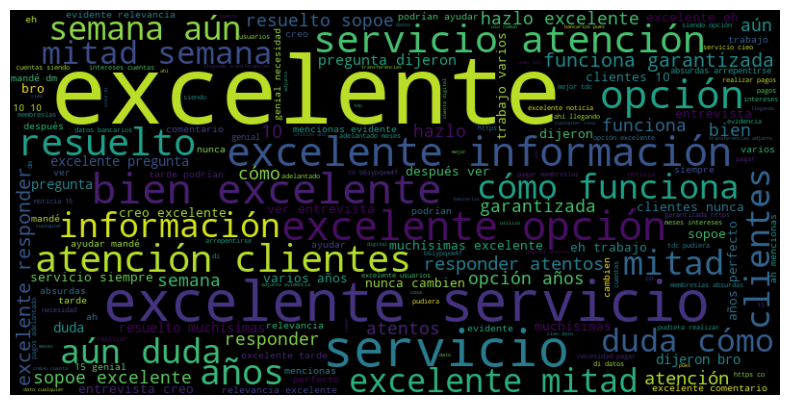

WordCloud for cluster 3


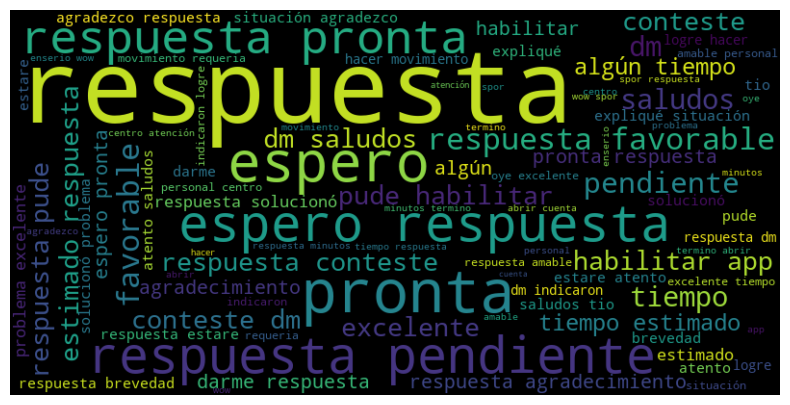

WordCloud for cluster 4


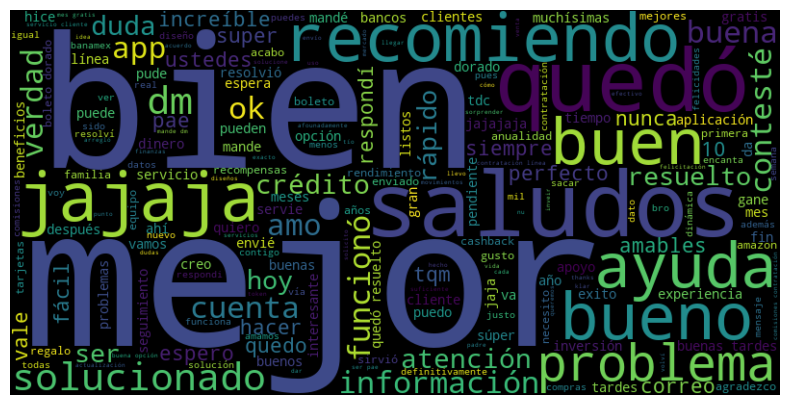

In [13]:
# Crear una función para generar WordClouds para cada cluster
def generate_wordclouds(cluster_model, terms):
    # Número de clusters
    n_clusters = cluster_model.n_clusters
    order_centroids = cluster_model.cluster_centers_.argsort()[:, ::-1]
    
    for i in range(n_clusters):
        print(f"WordCloud for cluster {i+1}")
        terms_freq = {}
        for ind in order_centroids[i, :]:  # Tomamos los top 10 términos de cada cluster
            terms_freq[terms[ind]] = cluster_model.cluster_centers_[i, ind]
        
        # Crear el WordCloud
        wc = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(terms_freq)
        
        # Visualización
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

generate_wordclouds(kmeans, terms)

In [14]:
from gensim import corpora, models
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

# Preprocessing the data
tokenizer = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer('spanish')

def preprocess(text):
    df1 = df.copy()
    tokens = tokenizer.tokenize(text.lower())
    #stemmed_tokens = [stemmer.stem(i) for i in tokens]
    return tokens

df4 = df2.copy()
df4['processed'] = df4['clean_tweet'].apply(preprocess)

# Creating a dictionary from the data
dictionary = corpora.Dictionary(df4['processed'])

# Creating a document-term matrix
corpus = [dictionary.doc2bow(text) for text in df4['processed']]

In [21]:
# Building the LDA model
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15, random_state=0)

# Printing the topics
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.008*"bien" + 0.008*"excelente" + 0.006*"cuenta" + 0.006*"mejor" + 0.005*"jajaja" + 0.005*"duda" + 0.005*"agradezco" + 0.005*"pueden" + 0.005*"funcionó" + 0.004*"verdad"')
(1, '0.013*"saludos" + 0.006*"información" + 0.006*"línea" + 0.006*"cliente" + 0.006*"contratación" + 0.006*"comisiones" + 0.005*"hoy" + 0.005*"rápido" + 0.005*"recomiendo" + 0.005*"servicio"')
(2, '0.011*"app" + 0.009*"cuenta" + 0.009*"atención" + 0.007*"problema" + 0.007*"recomiendo" + 0.007*"bien" + 0.006*"crédito" + 0.005*"amo" + 0.005*"vamos" + 0.005*"ser"')
(3, '0.012*"mejor" + 0.008*"dm" + 0.007*"respuesta" + 0.006*"opción" + 0.006*"buen" + 0.006*"bueno" + 0.006*"quedó" + 0.006*"ayuda" + 0.005*"buena" + 0.004*"ahí"')
(4, '0.006*"mes" + 0.006*"10" + 0.006*"meses" + 0.006*"dinero" + 0.006*"clientes" + 0.005*"mejor" + 0.005*"da" + 0.005*"rendimiento" + 0.004*"crédito" + 0.004*"uso"')


**Topics**
- 0: Comentario Positivo General
- 1: Contrataciones
- 2: Aplicación
- 3: Ayuda
- 4: Crédito

In [22]:
lda_model.show_topic(1)

[('saludos', 0.013229566),
 ('información', 0.006183818),
 ('línea', 0.0061087157),
 ('cliente', 0.006101156),
 ('contratación', 0.0060932525),
 ('comisiones', 0.006093201),
 ('hoy', 0.0053583807),
 ('rápido', 0.0053450316),
 ('recomiendo', 0.0050463052),
 ('servicio', 0.004843774)]

## Dataset con Sentimiento

In [30]:
# Palabras por tópico
topics_words = {}

for i in range(5):
    topics = lda_model.show_topic(i)
    words = []
    for topic, score in topics:
        words.append(topic)
    topics_words[i] = words

# Crear columnas para cada palabra clave
for topic, words in topics_words.items():
    for word in words:
        df4[word] = df4['processed'].apply(lambda x: x.count(word))

# Ahora, añadir una columna para el tópico predominante de cada texto
def determine_topic(text):
    scores = {topic: sum(text.count(word) for word in words) for topic, words in topics_words.items()}
    return max(scores, key=scores.get)

df4['main_topic'] = df4['processed'].apply(determine_topic)
df4.head()

,date,time,tweet,clean_tweet,processed,bien,excelente,cuenta,mejor,jajaja,...,ahí,mes,10,meses,dinero,clientes,da,rendimiento,uso,main_topic
0,2023-01-01,NaN,"Resuelto, muchísimas gracias , excelente servi...","resuelto , muchísimas , excelente servicio sie...","[resuelto, muchísimas, excelente, servicio, si...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-01-02,NaN,"Muchas gracias, espero su dm",", espero dm","[espero, dm]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,2023-01-02,NaN,Muchas gracias!,!,[],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-01-02,NaN,Algo similar me paso. Quería renovar mi token ...,similar paso . quería renovar token poder hace...,"[similar, paso, quería, renovar, token, poder,...",0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2023-01-02,NaN,Yeeeei! a través de mi cuenta en acabo de cont...,yeeeei ! través cuenta acabo contratar cuenta ...,"[yeeeei, través, cuenta, acabo, contratar, cue...",0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,2


## Clasificación de textos en base a features

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

df5 = df4.copy()

X = df5.iloc[:,5:-1]
y = df5.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [51]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       102
           1       0.85      0.69      0.76        16
           2       1.00      0.44      0.61        16
           3       1.00      0.67      0.80        18
           4       1.00      0.64      0.78        11

    accuracy                           0.85       163
   macro avg       0.93      0.68      0.77       163
weighted avg       0.87      0.85      0.83       163



In [52]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       102
           1       0.86      0.75      0.80        16
           2       1.00      0.88      0.93        16
           3       0.93      0.78      0.85        18
           4       0.73      0.73      0.73        11

    accuracy                           0.90       163
   macro avg       0.89      0.82      0.85       163
weighted avg       0.90      0.90      0.90       163



In [53]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       102
           1       0.79      0.94      0.86        16
           2       0.88      0.88      0.88        16
           3       0.85      0.94      0.89        18
           4       0.83      0.91      0.87        11

    accuracy                           0.93       163
   macro avg       0.87      0.92      0.89       163
weighted avg       0.93      0.93      0.93       163



In [54]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       102
           1       0.88      0.88      0.88        16
           2       1.00      1.00      1.00        16
           3       0.94      0.89      0.91        18
           4       0.77      0.91      0.83        11

    accuracy                           0.95       163
   macro avg       0.91      0.93      0.92       163
weighted avg       0.95      0.95      0.95       163

